# Supervised learning- tree-based methods + whitening the blackbox

# 0. Loading packages and dataset

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

df = pd.read_csv('real_estate_cleaned.csv')

C:\Users\ines.devlieger\AppData\Local\Temp\ipykernel_22396\2606113159.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# 1. Taking a look at the data

In [24]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,restaurants,groceries,nightlife,cafes,...,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition,roof_Gravel/rock,roof_Missing,roof_Other,roof_Shake shingle,basement_1.0,basement_Missing
0,12.597611,1,1,6.371612,2013,8.388054,4.682131,2.302585,3.433987,2.995732,...,0,1,0,0,0,1,0,0,0,1
1,12.285350,1,1,6.418365,1965,8.388054,4.663439,2.772589,1.945910,2.639057,...,0,0,0,1,0,0,0,0,1,0
2,12.542191,1,1,6.423247,1963,8.388054,5.214936,2.639057,3.465736,3.433987,...,0,1,0,0,0,1,0,0,0,1
3,12.847666,1,1,6.428105,2000,10.420554,5.293305,2.302585,3.663562,3.258097,...,0,1,0,0,0,1,0,0,0,1
4,12.736704,1,1,6.453625,1992,8.388054,5.010635,2.079442,3.135494,3.044522,...,0,0,0,0,0,1,0,0,0,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tx_price                            803 non-null    float64
 1   beds                                803 non-null    int64  
 2   baths                               803 non-null    int64  
 3   sqft                                803 non-null    float64
 4   year_built                          803 non-null    int64  
 5   lot_size                            803 non-null    float64
 6   restaurants                         803 non-null    float64
 7   groceries                           803 non-null    float64
 8   nightlife                           803 non-null    float64
 9   cafes                               803 non-null    float64
 10  shopping                            803 non-null    float64
 11  arts_entertainment                  803 non-n

# 2. Train/test-split

In [26]:
# shuffle
from random import Random
df.iloc[:,25:39] = df.iloc[:,25:39].astype(np.uint8)

df_shuffle = df.sample(frac=1, random_state=123)

# split
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(['tx_price'],1)
y = df_shuffle['tx_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# standardise
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
X_train_stand[num_feat] = scaler.transform(X_train[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

X_test_stand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 7 to 599
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   beds                                161 non-null    float64
 1   baths                               161 non-null    float64
 2   sqft                                161 non-null    float64
 3   year_built                          161 non-null    float64
 4   lot_size                            161 non-null    float64
 5   restaurants                         161 non-null    float64
 6   groceries                           161 non-null    float64
 7   nightlife                           161 non-null    float64
 8   cafes                               161 non-null    float64
 9   shopping                            161 non-null    float64
 10  arts_entertainment                  161 non-null    float64
 11  beauty_spas                         161 non-n

C:\Users\ines.devlieger\AppData\Local\Temp\ipykernel_22396\1505123134.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,25:39] = df.iloc[:,25:39].astype(np.uint8)
C:\Users\ines.devlieger\AppData\Local\Temp\ipykernel_22396\1505123134.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['tx_price'],1)


# 3. Decision trees

1. Perform a crossvalidation, using DecisionTreeRegressor, with depth ranging from 1 to 50
  
2. Plot the depth to the R2
    + First do a general plot
    + Then zoom in on the highest values 
    + Which depth leads to the highest R2?
    + How do you explain the horizontal line on the right side of the general plot? Or in other words: how come the R2 remains constant as the depth increases?
    




1. cross-validation

In [27]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_score

depth = np.arange(1,50)    # This will give an array of numbers between 1 and 10
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=d)  
    scores = cross_val_score(dec_tree, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 


2. plots

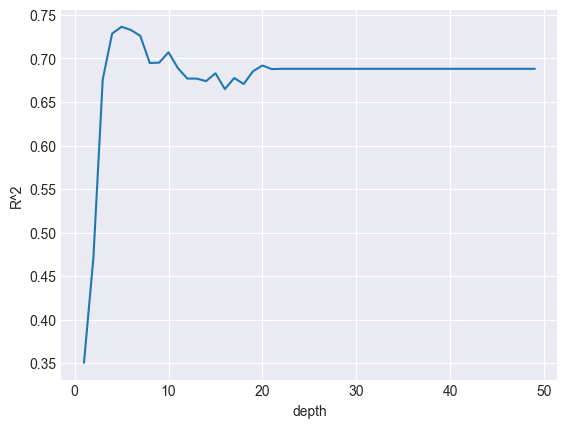

The best depth is 5


In [28]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(depth, cv_scores)
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index])

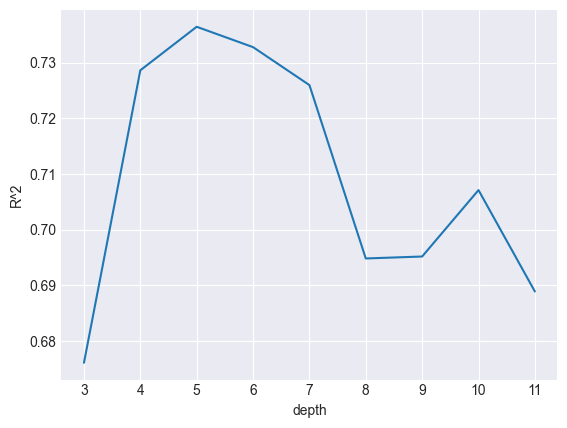

The best depth is 5
The best validation scoer is 0.7364177734388406


In [29]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(depth[2:11], cv_scores[2:11])
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index])
print('The best validation scoer is', max_value)

+ A depth of 5 gives the best model
+ The more simple model with a dept of 4 is above the lower boundary, so this is the optimal model.
+ The horizontal line can be explained by the fact the maximum depth of a decision tree is limited. We can see that at around a depth of 21 all observations are in a leaf of their own, so no more splitting is possible.

3. Retrain and test

In [30]:
from sklearn import tree  
dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=4)  
dec_tree.fit(X_train_stand, y_train) 
print(dec_tree.score(X_train_stand, y_train) )
dec_tree.score(X_test_stand, y_test) 

0.8147975018568473


0.7498618816083306

This is already better than any of the model we have tried before. And we have just used the most simple tree-based model.

# 4. Random forest
Let's see if we can improve the previous result by using random forests. 

1. Perform a  random search cross-validation using  RandomForestRegressor with the following hyperparameters
    + criterion: squared_error, absolute_error
    + n_estimators: choose 200 values, ranging from 100 to 500
    + max_features: auto, sqrt, log2
    + max_depth: let it range from 1 to 15
    + min_samples_split: let it range from 2 to 15: why not from 1 to 15?
    + min_samples_leaf: let it range from 1 to 15
    + max_leaf_nodes: choose 490 values, ranging from 10 to 500
    
    + use random_state=42
    + use 3 folds
    + fit 100 random models
    
2. Print out the validated $R^2$ for the best model from the random search 
 
3. Print out the parameters of the best model
 
4. Plot the results for all hyperparameters
     + First make a general plot for all results and all hyperparameters
     + Then make plots for all hyperparameters, but only the models where the R2 is above 0.7, to get a better idea which parameters you will use in the grid search.
     
5. Perform a grid search. Choose the parameters that you include in this search yourself
      + Since this is just a labo and you do not want to wait hours for the results, limit the choices. For an assignment, you should add more options.
      + print out the best model
    

1. Random search

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 200)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validatoin
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
rf_random.fit(X_train_stand, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 150, 152, 154,
                                                         156, 158, ...]},
                   random_state=42, verbose=2)

2. Print out the training and validated $R^2$ for the best model from the random search 

In [32]:
print(rf_random.score(X_train_stand, y_train))
print(rf_random.best_score_)

0.9359272038574955
0.8058109936344762


3. print out the parameters of the best model

In [33]:
rf_random.best_params_

{'n_estimators': 234,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_leaf_nodes': 60,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'squared_error'}

4. Plot the results  for the hyperparameters

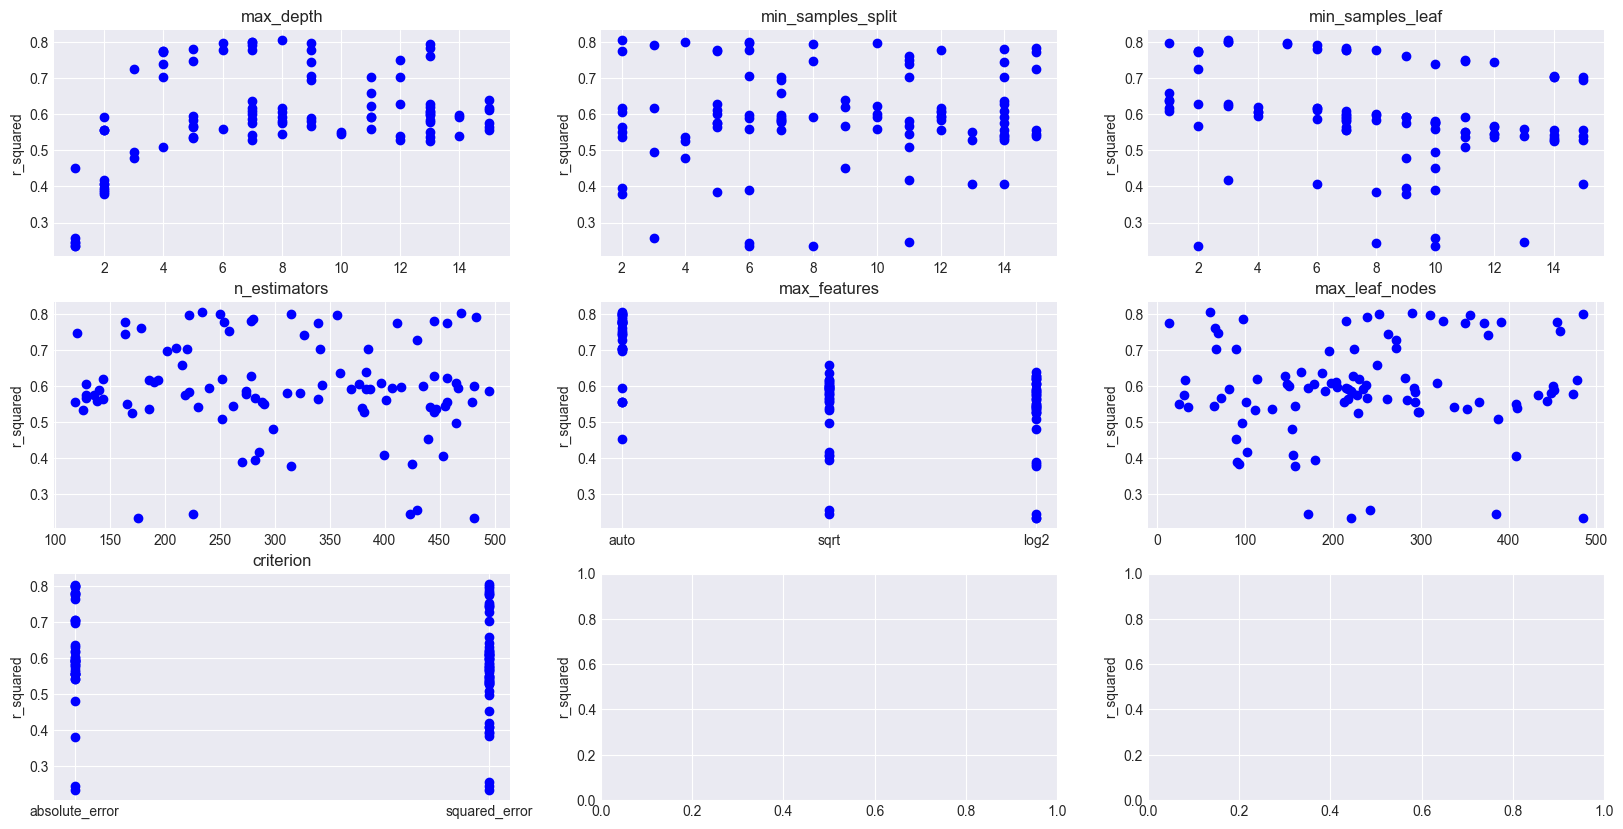

In [34]:
out = pd.DataFrame(rf_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')
    

In [35]:
out = out[out.mean_test_score > 0.7]

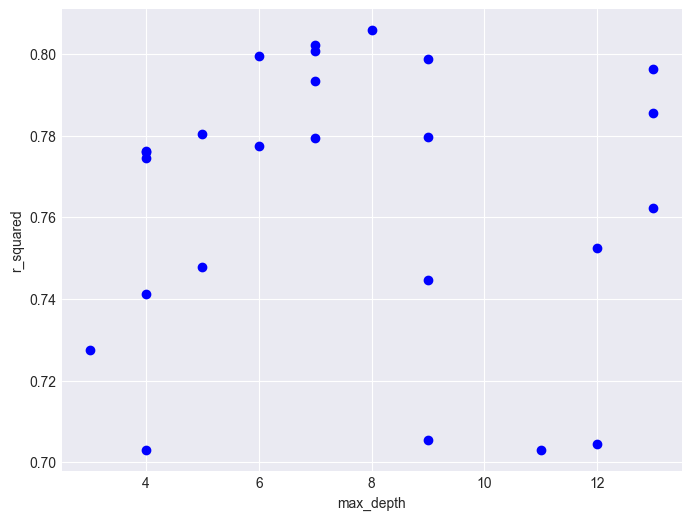

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
ax.set_xlabel("max_depth");
ax.set_ylabel("r_squared");

We can see that the best depth is 8, but 7 and 9 do not perform much worse. However, we prefer models that are less complex. Here, that means models that are less deep. So, we chose 7 and 8 to go in the grid search.

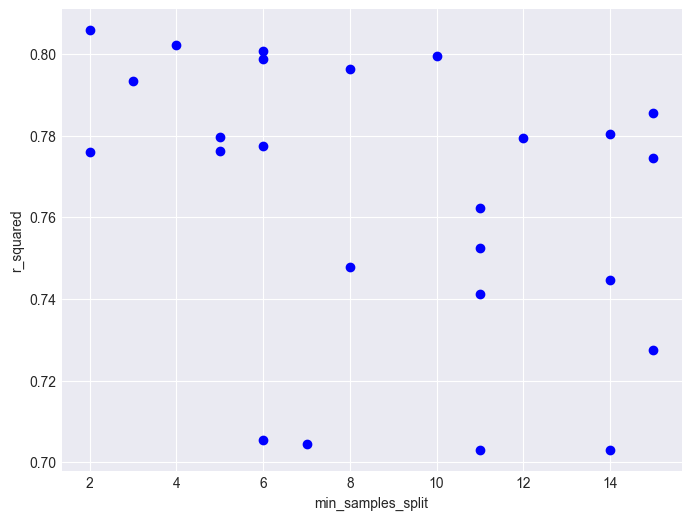

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
ax.set_xlabel("min_samples_split");
ax.set_ylabel("r_squared");

We can see that the best value is 2, but 4 does not perform much worse. However, we prefer models that are less complex. Here, that means models that have a higher min number of samples to allow splitting. So, we chose 2 and 4 to go in the grid search.

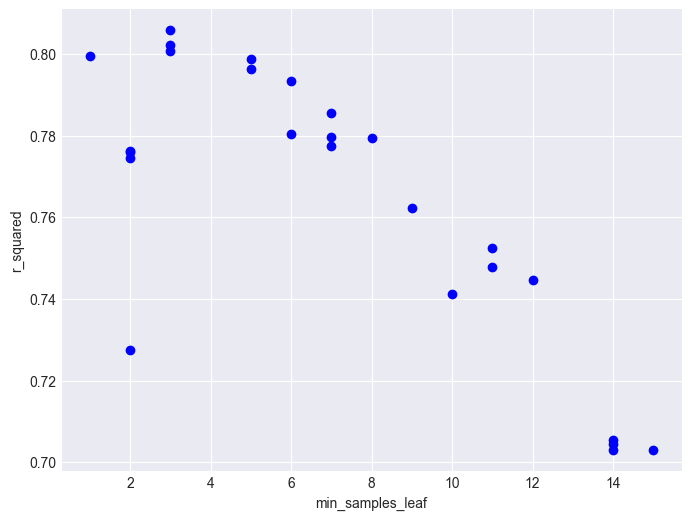

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
ax.set_xlabel("min_samples_leaf");
ax.set_ylabel("r_squared");

3 leads to the best R^2, but 5 is not that much worse. We prefer a higher number of samples in a leaf (less complex), thus we include 3 and 5.

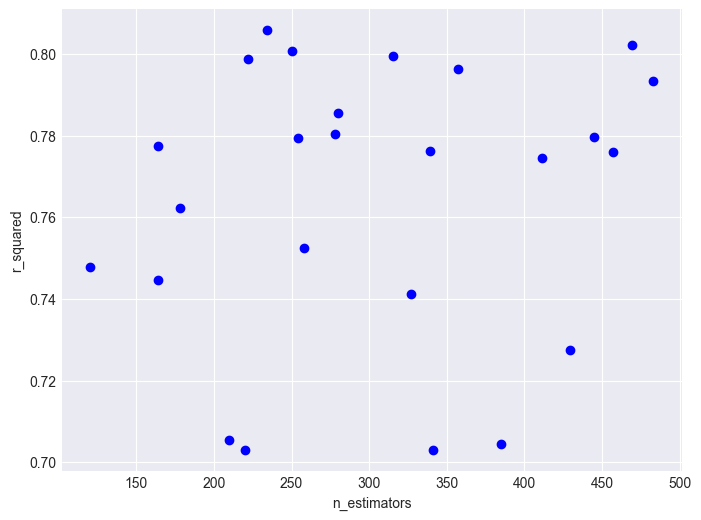

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
ax.set_xlabel("n_estimators");
ax.set_ylabel("r_squared");

The best value was with 234 trees, but around 230 does not perform much worse. Let's add 230,232 and 234 to the grid search.

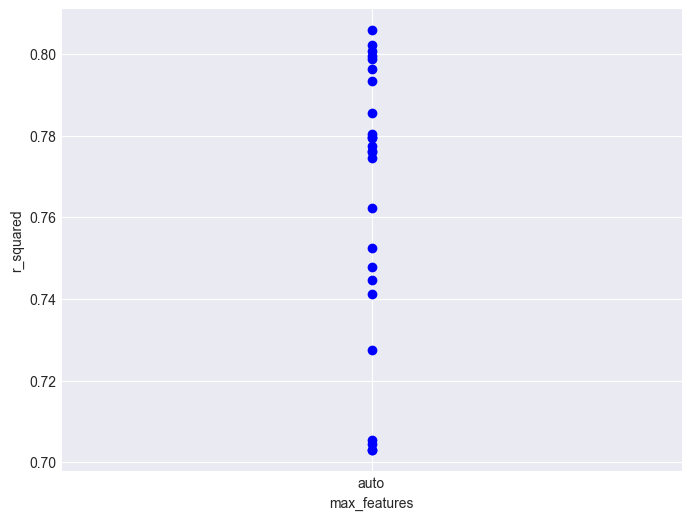

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_max_features'], out['mean_test_score'], c='blue');
ax.set_xlabel("max_features");
ax.set_ylabel("r_squared");

Auto clearly wins here, so let's just go with that.

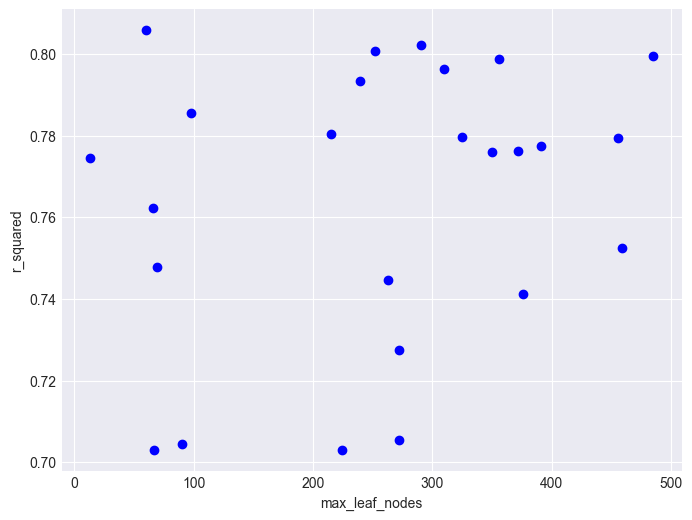

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
ax.set_xlabel("max_leaf_nodes");
ax.set_ylabel("r_squared");

The best max_leaf_nodes was 60, but around 290 is not much worse. Let's add 60 and 290 to the grid search.

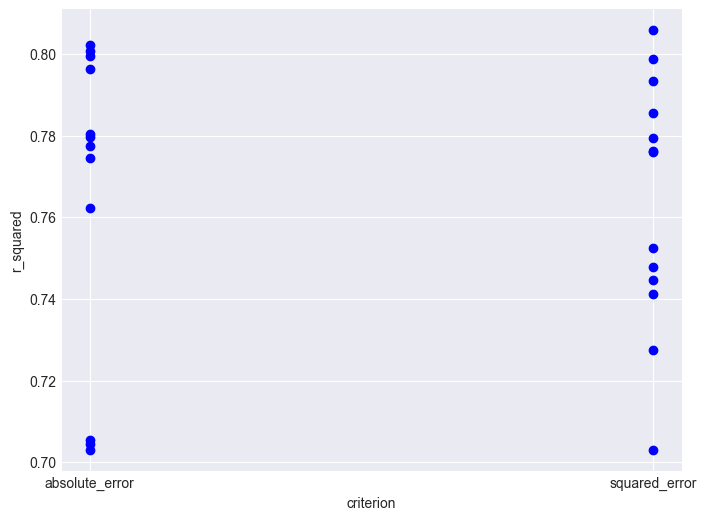

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_criterion'], out['mean_test_score'], c='blue');
ax.set_xlabel("criterion");
ax.set_ylabel("r_squared");

mse had the best score,we use mse

5. Grid search

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =[ 'squared_error']
n_estimators = [230, 232,234]
max_features = ['auto']
max_depth = [7,8]
min_samples_split = [2,4]
min_samples_leaf = [3,5]
max_leaf_nodes = [60, 290]


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validatoin
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf, param_grid = grid,
                               cv = 5, verbose=2,  n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
rf_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [7, 8],
                         'max_features': ['auto'], 'max_leaf_nodes': [60, 290],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [2, 4],
                         'n_estimators': [230, 232, 234]},
             verbose=2)

In [44]:
rf_grid.best_params_

{'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': 60,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 230}

Not a lot has changed, this is not that unexpected, because we did not give a lot of options in the grid search. I would try a little harder for an assignment.

In [46]:

print('R2: %.3f' % rf_grid.score(X_train_stand, y_train))
print('R2: %.3f' % rf_grid.best_score_)

params = rf_grid.best_params_
rf_gridBest = RandomForestRegressor(**params)
rf_gridBest.fit(X_train_stand, y_train)

R2: 0.936
R2: 0.821


c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=8, max_features='auto', max_leaf_nodes=60,
                      min_samples_leaf=3, n_estimators=230)

The random forest gives us the best model untill now. (compared to linear regression, lasso regression and random forest). 

# 3. Whitening the black box

Untill know we have focussed on getting a model that performs as best as possible. But let's shift our attention now. How do we interpret these models?
1. Which features are important: Plot the feature importances
    + Which five features are most important?
2. What is the influence of a certain feature?
    + Get the predictions from the random forest.
    + Perform one univariate linear regressions per feature on the predicted values!
        + Use the standardized features and also standardize the predictions, to make the interpretation easier 
    + Look at the direction of the effect for the five most important features
3. Why is a prediction what it is?	
    + Use lime to get an idea of how the prediction of observation 100 was made

1. Plot the feature importances

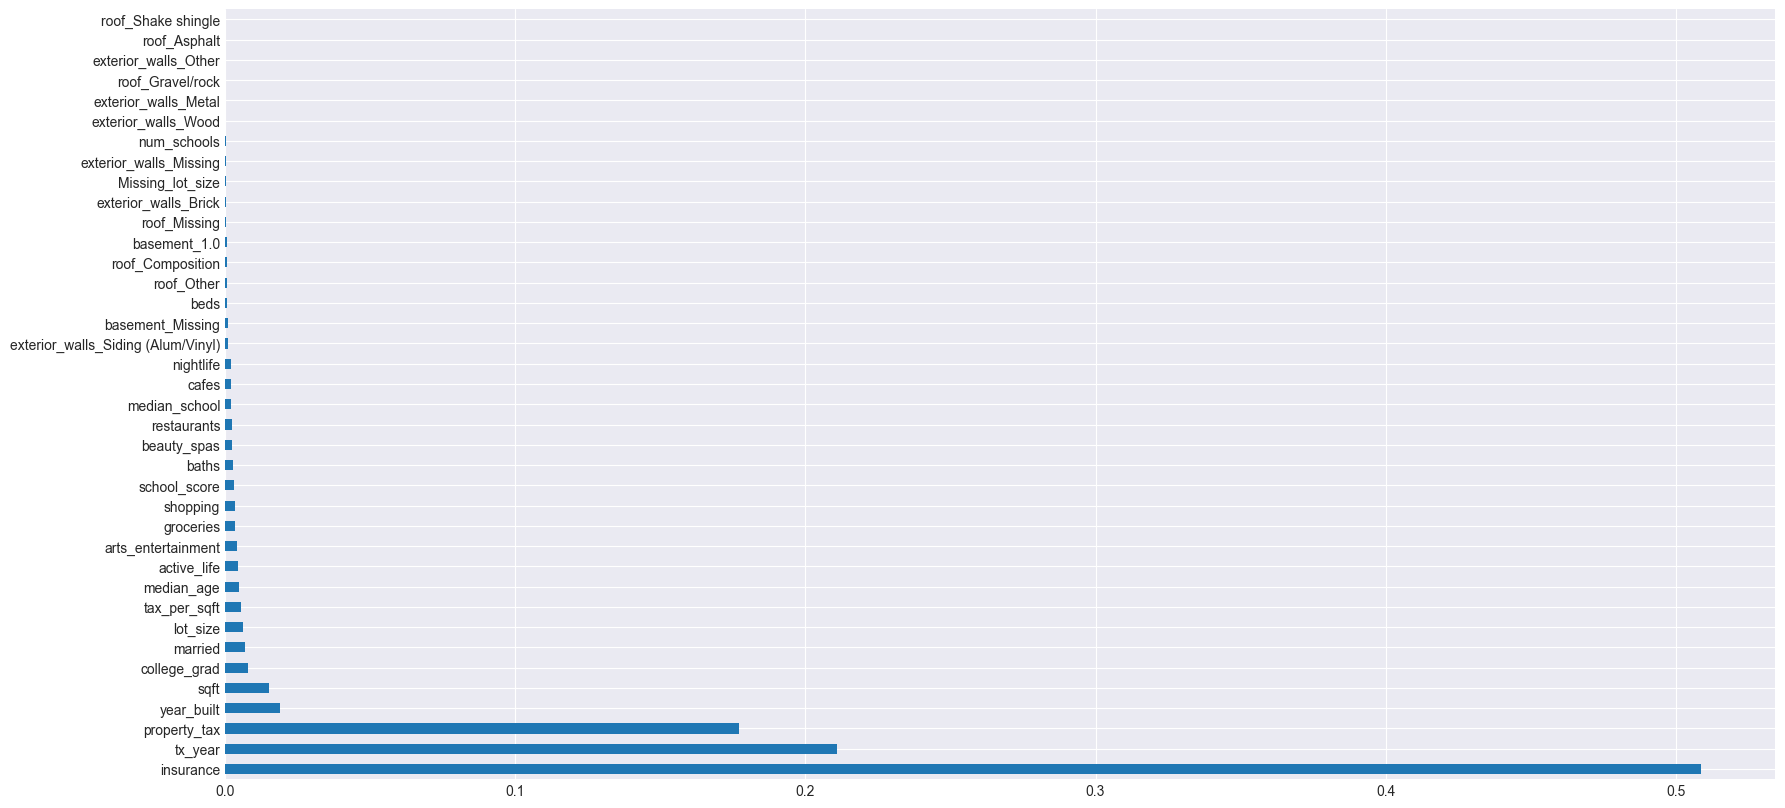

In [47]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))

feat_importances = pd.Series(rf_gridBest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(38).plot(kind='barh')
plt.show()

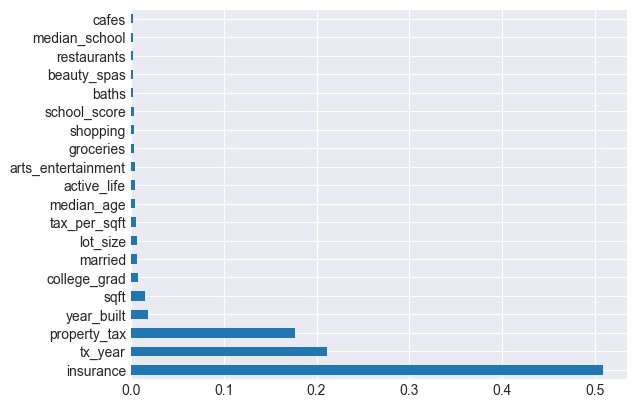

In [48]:
plt.figure()

feat_importances.nlargest(20).plot(kind='barh')
plt.show()

So, the five features that seem to have the most influence in our algorithm are the cost for insuring the house, the year the taxation is made, the hight of the property tax, the year built and the square feet.

But what is the direction of this influence? Here, you might guess it from the context ( a house with a higher insurance cost, will probably have a higher price), but be carefull with making assumptions like that. There is always a chance that you are wrong. So you have to check the directions of the influences yourself.




2. What is the influence of a certain feature?

+ get the predictions from the random forest.

In [49]:
pred_train =rf_gridBest.predict(X_train_stand)

+ Perform one univariate linear regressions per feature on the predicted values!

In [54]:
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(X_train_stand)
X.columns = X_train.columns
predictors =  X_train.columns
y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)

reg = LinearRegression().fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])
for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression().fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)
betas = pd.concat([names,beta],axis=1)
betas


,0,1
0,beds,0.268962
0,baths,0.323642
0,sqft,0.436166
0,year_built,0.234705
0,lot_size,-0.091907
0,restaurants,0.139183
0,groceries,0.090128
0,nightlife,0.160374
0,cafes,0.159613
0,shopping,0.128423


We can see that the higher the sqft, the higher the price;  the higher the property tax, the higher the price;...


3. Why is a prediction what it is?


In [55]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer


# creating the explainer function
explainer = LimeTabularExplainer(X_train_stand.values, mode="regression", feature_names=X_train.columns)

# storing a new observation
i = 100
X_test_stand = pd.DataFrame(X_test_stand)
X_test_stand.columns = X_train.columns

X_observation = X_test_stand.iloc[[i], :]

In [56]:
# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], rf_gridBest.predict)
explanation.show_in_notebook(show_table=True, show_all=False)


c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


We can see that the prediction for this point is 12.93 (middel of the left bar). By permuting the values of the different features, the prediction ranged from 12.33 to 13.49. In the table on the right, we can see the point itself. In the graph in the middle, you can see how the features influence the point. So, if the insurance is above 0;55, this will have a positive impact on the prediction (the prediction will be higher).

# 5. Gradient boosting
Let's try one last algorithm for regression. 

1. Perform a  random search cross-validation using  GradientBoostingRegressor with the following hyperparameters
    + criterion: squarred_error
    + n_estimators: choose 50 values, ranging from 100 to 500
    + max_features: auto, sqrt, log2
    + max_depth: let it range from 1 to 15
    + min_samples_split: let it range from 2 to 15: why not from 1 to 15?
    + min_samples_leaf: let it range from 1 to 15
    + max_leaf_nodes: choose 50 values, ranging from 10 to 500
    + loss:  huber
    + learning_rate = choose 10 values, ranging from 0.01 to 1
    
    + use random_state=42
    + use 3 folds
    + fit 100 random models
    
2. Print out the validated $R^2$ for the best model from the random search 

3. Print out the parameters of the best model
 
4. Plot the results for all hyperparameters
     + First make a general plot for all results and all hyperparameters
     + Then make plots for all hyperparameters, but only the models where the R2 is above 0.7, to get a better idea which parameters you will use in the grid search.
     
5. Perform a grid search. Choose the parameters that you include in this search yourself
      + Since this is just a labo and you do not want to wait hours for the results, limit the choices. For an assignment, you could add more options.
      + print out the best model
      + Test the model 
    

1. Perform random search

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

criterion =['squared_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['huber']
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
X_train_stand.info()
gbm_random.fit(X_train_stand, y_train)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 611 to 128
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   beds                                642 non-null    float64
 1   baths                               642 non-null    float64
 2   sqft                                642 non-null    float64
 3   year_built                          642 non-null    float64
 4   lot_size                            642 non-null    float64
 5   restaurants                         642 non-null    float64
 6   groceries                           642 non-null    float64
 7   nightlife                           642 non-null    float64
 8   cafes                               642 non-null    float64
 9   shopping                            642 non-null    float64
 10  arts_entertainment                  642 non-null    float64
 11  beauty_spas                         642 non

c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0],
                                        'loss': ['huber'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90, 100,
                                                           110,...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

2. Print out the validated $R^2$ for the best model from the random search 

In [68]:
print(gbm_random.score(X_train_stand, y_train))
gbm_random.best_score_


0.9458334117621092


0.8255281117408036

3. print out the parameters of the best model

In [69]:
gbm_random.best_params_

{'n_estimators': 157,
 'min_samples_split': 5,
 'min_samples_leaf': 7,
 'max_leaf_nodes': 230,
 'max_features': 'auto',
 'max_depth': 3,
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

4. Plot the results of the hyperparameters

In [70]:
out = pd.DataFrame(gbm_random.cv_results_)
out.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_loss,param_learning_rate,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,17.525818,2.949335,0.041224,0.037849,467,5,3,390,log2,7,huber,0.9,squared_error,"{'n_estimators': 467, 'min_samples_split': 5, ...",0.407406,0.368335,0.321789,0.365843,0.034997,98
1,22.304083,4.188319,0.036237,0.035029,393,10,4,60,auto,7,huber,0.3,squared_error,"{'n_estimators': 393, 'min_samples_split': 10,...",0.786317,0.851957,0.784508,0.807594,0.031378,8
2,2.544689,1.029889,0.005317,0.000467,181,2,1,10,sqrt,2,huber,0.9,squared_error,"{'n_estimators': 181, 'min_samples_split': 2, ...",0.658953,0.652450,0.479649,0.597018,0.083034,75
3,6.639208,2.876818,0.033577,0.036909,206,3,15,450,log2,6,huber,0.6,squared_error,"{'n_estimators': 206, 'min_samples_split': 3, ...",0.588779,0.715549,0.679202,0.661176,0.053300,61
4,8.995599,2.348447,0.011635,0.001244,230,8,7,410,sqrt,9,huber,0.7,squared_error,"{'n_estimators': 230, 'min_samples_split': 8, ...",0.534409,0.611624,0.555128,0.567054,0.032631,80


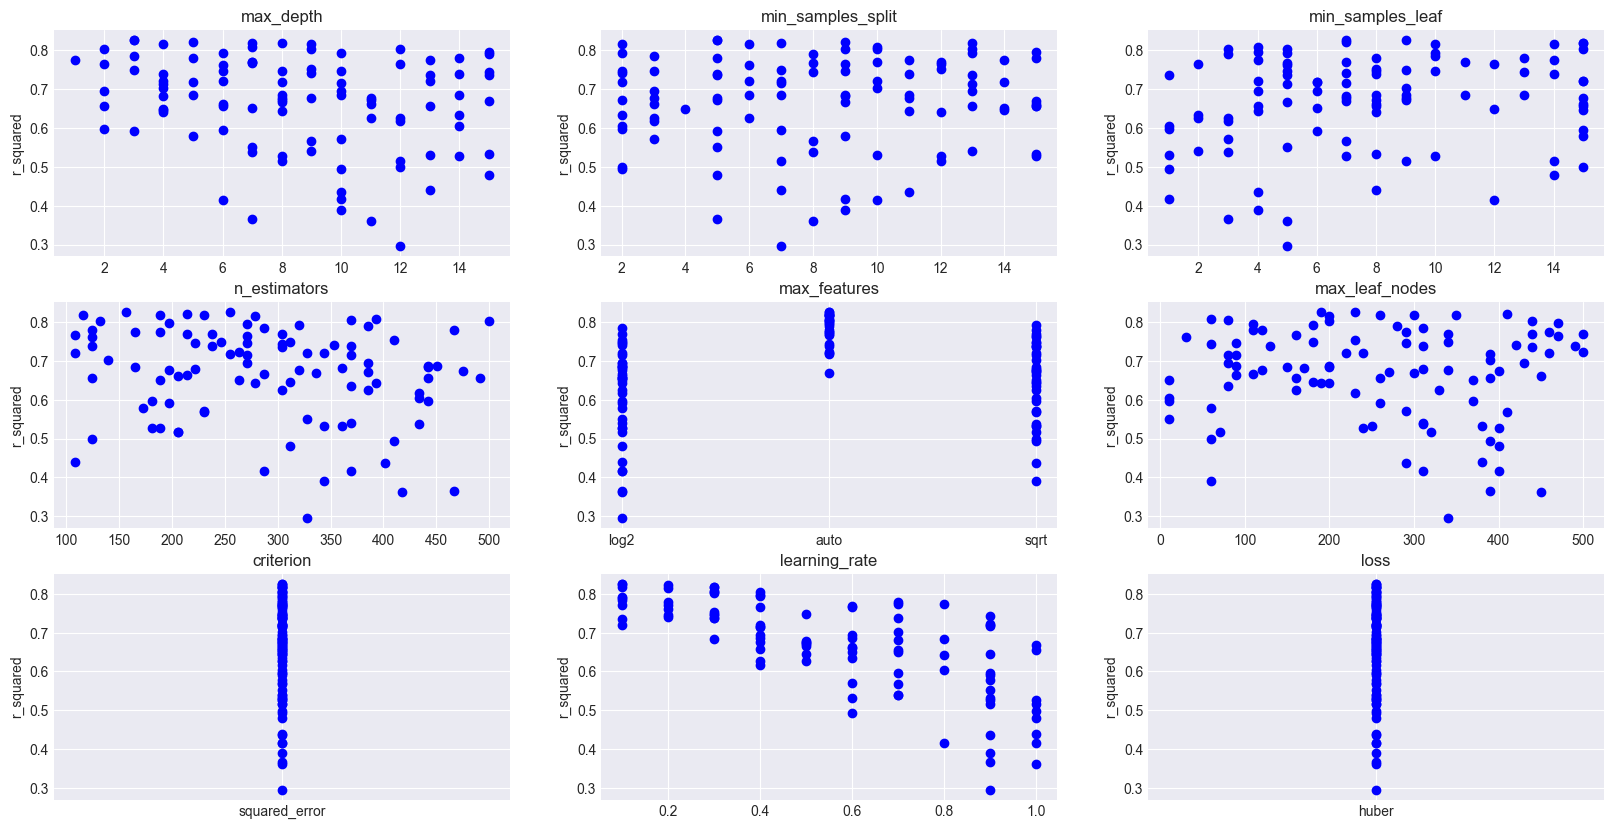

In [71]:
out2 = out

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out2['param_max_features'], out2['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out2['param_max_leaf_nodes'], out2['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out2['param_criterion'], out2['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

axs[2,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue');
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out2['param_loss'], out2['mean_test_score'], c='blue');
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

It is hard to see anything on these graphs, because of some very low scores. We will zoom in on the R^2 above 0.6

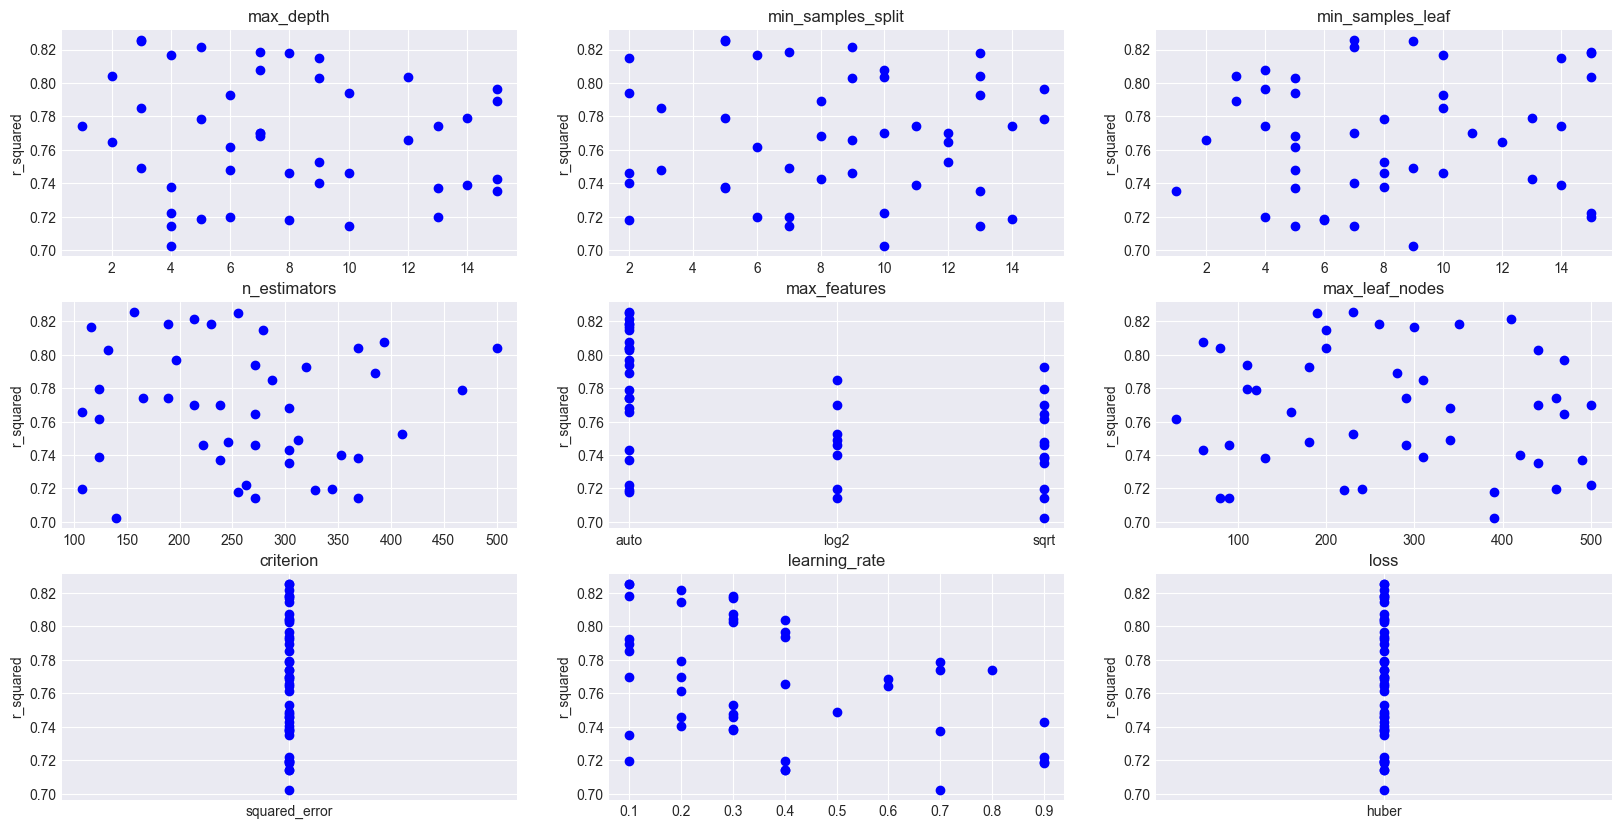

In [72]:
out2 = out[out.mean_test_score > 0.7]


xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out2['param_max_features'], out2['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out2['param_max_leaf_nodes'], out2['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out2['param_criterion'], out2['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

axs[2,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue');
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out2['param_loss'], out2['mean_test_score'], c='blue');
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')
    

5. Grid search

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error']
n_estimators = [214, 251]
max_features = ['auto']
max_depth = [3,5]
min_samples_split = [9]
min_samples_leaf = [7,9]
max_leaf_nodes = [198,410]
learning_rate = [0.09,0.1,0.11,0.12,0.13]
loss = ['huber']

# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            'max_leaf_nodes': max_leaf_nodes,
               'learning_rate': learning_rate,
               'loss':loss}

# then do cross-validatoin
gbm = GradientBoostingRegressor()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = grid,
                               cv = 5, verbose=2,  n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
gbm_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'learning_rate': [0.09, 0.1, 0.11, 0.12, 0.13],
                         'loss': ['huber'], 'max_depth': [3, 5],
                         'max_features': ['auto'], 'max_leaf_nodes': [198, 410],
                         'min_samples_leaf': [7, 9], 'min_samples_split': [9],
                         'n_estimators': [214, 251]},
             verbose=2)

In [76]:
gbm_grid.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 198,
 'min_samples_leaf': 7,
 'min_samples_split': 9,
 'n_estimators': 214}

In [77]:
print(gbm_random.score(X_train_stand, y_train))
gbm_random.best_score_

0.9458334117621092


0.8255281117408036

# 6. Final evaluation
+ Choose the model with the best validated score from this labo
+ Retrain the model on the whole training set
+ Evaluate on the test set

NOw that we have compared all algorithms, we choose the algorithm with the highest validated score. Retrain this algorithm on the whole dataset 

In [78]:
params = gbm_grid.best_params_
gbm_gridBest = GradientBoostingRegressor(**params)
gbm_gridBest.fit(X_train, y_train)
print(gbm_gridBest.score(X_train, y_train))
print(gbm_gridBest.score(X_test, y_test))

c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been

0.9576617566874037
0.8230103920395286


c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been

Our model has a reliability of 82%